In [214]:
import numpy as np
from scipy.constants import e, m_p, m_e, c, epsilon_0, m_n, k as kb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cycler import cycler
import glob, os
from astropy.io import fits
from scipy.ndimage import label, center_of_mass

plt.rcParams.update({
    # Color cycle
    "axes.prop_cycle": cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']),

    # Figure size
    "figure.figsize": (4, 3),

    # X ticks
    "xtick.direction": "in",
    "xtick.major.size": 3,
    "xtick.major.width": 0.5,
    "xtick.minor.size": 1.5,
    "xtick.minor.width": 0.5,
    "xtick.minor.visible": True,
    "xtick.top": True,

    # Y ticks
    "ytick.direction": "in",
    "ytick.major.size": 3,
    "ytick.major.width": 0.5,
    "ytick.minor.size": 1.5,
    "ytick.minor.width": 0.5,
    "ytick.minor.visible": True,
    "ytick.right": True,

    # Axes & lines
    "axes.linewidth": 0.5,
    "grid.linewidth": 0.5,
    "lines.linewidth": 1.0,

    # Font & math
    "font.family": "sans-serif",
    #"mathtext.fontset": "dejavuserif",
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",

    # Legend & saving
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})


# Plotting the image

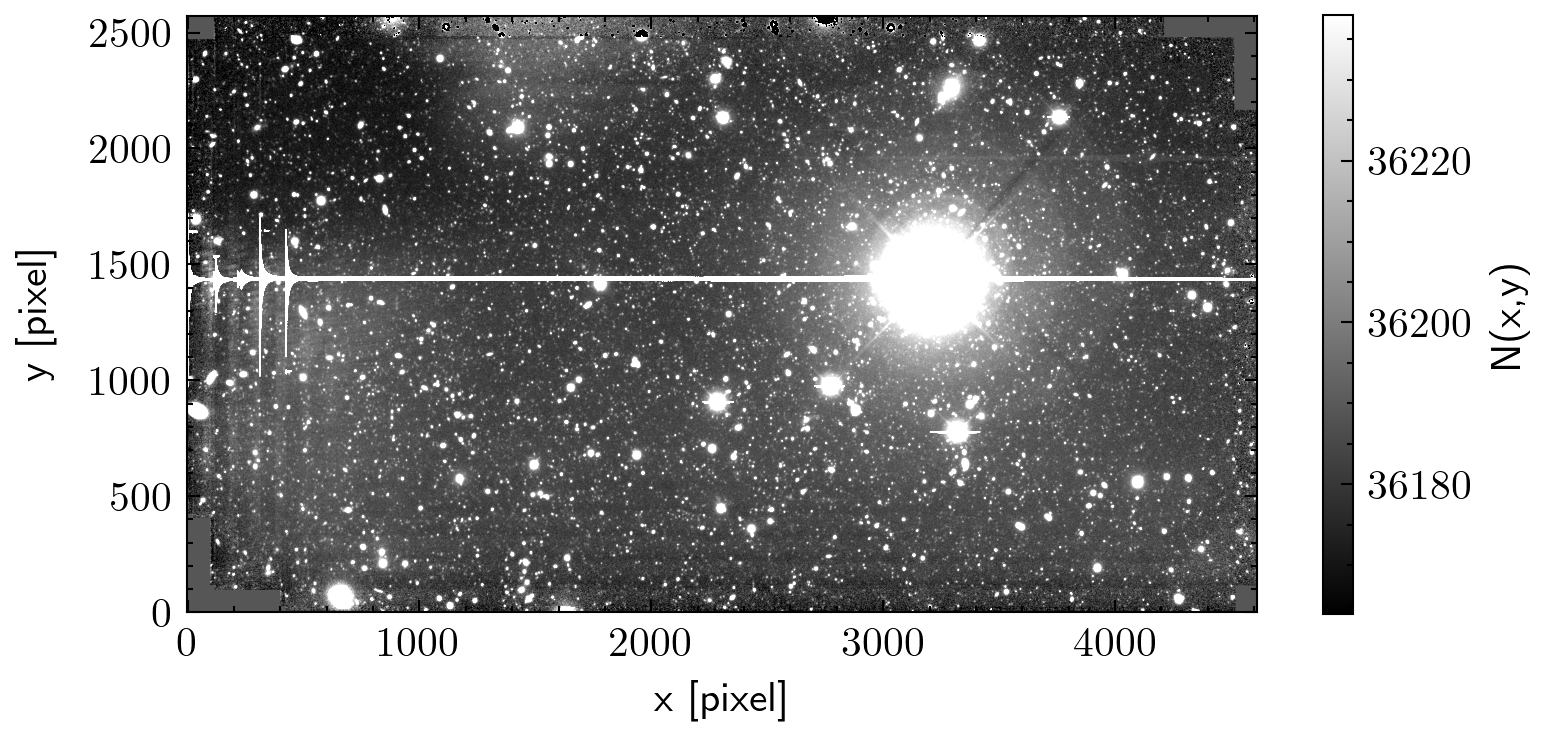

In [205]:
# Load the FITS file
with fits.open("data/Fits_Data/mosaic.fits") as hdul:
    image_data = hdul[0].data # this contains the count in each pixel
    header = hdul[0].header

# Apply scaling
# REAL = TAPE*BSCALE + BZERO                     
scaled_image = image_data.T * header.get('BSCALE', 1) + header.get('BZERO', 0)

# Get aspect ratio (width / height)
ny, nx = scaled_image.shape
aspect_ratio = nx / ny
enlarge = 1

# Plot
plt.figure(figsize=(3 * aspect_ratio * enlarge, 3 * enlarge), dpi=300)
plt.imshow(
    scaled_image,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(scaled_image, 5),
    vmax=np.percentile(scaled_image, 95)
)
plt.title('')
plt.colorbar(label='N(x,y)', shrink=0.78)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()

# Examine the distribution in the count values

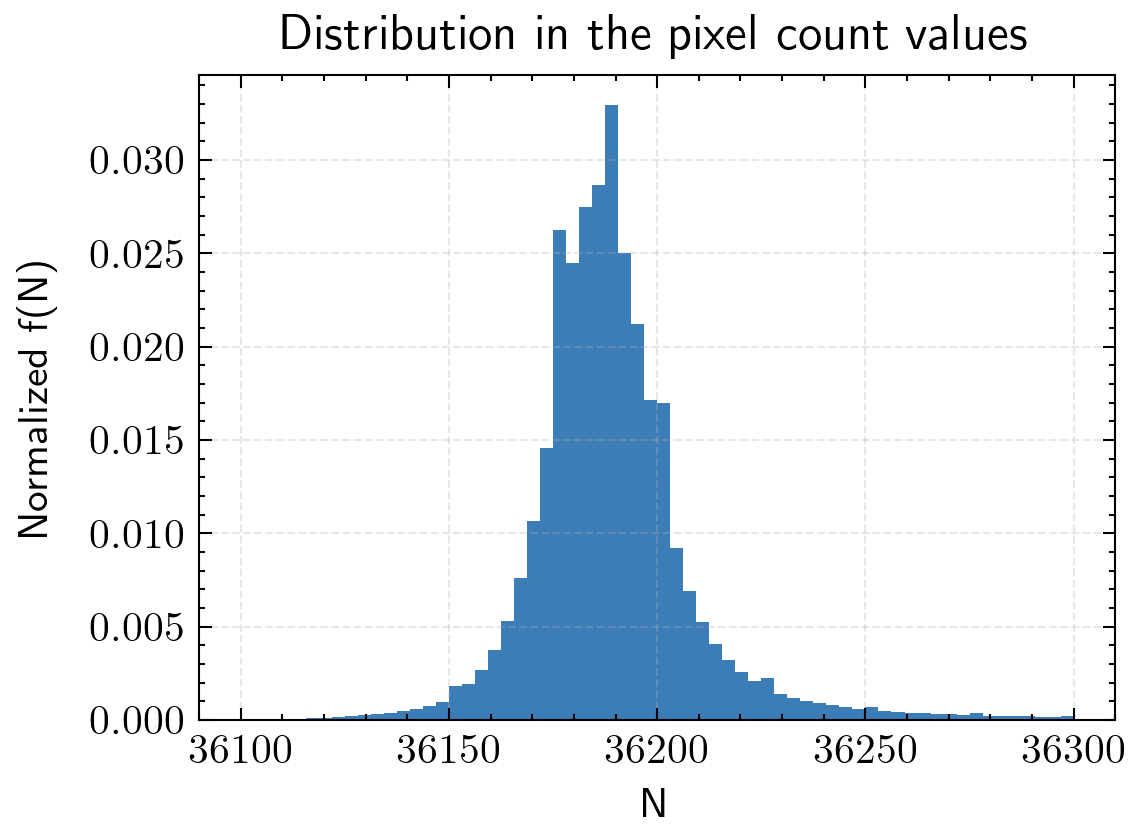

Mean: 36189.056
Std:  19.263


In [206]:
# Flatten to 1D array of counts
pixels = scaled_image.flatten()

# Define range
min_count, max_count = 36.1e3, 36.3e3

# Mask pixels within range
mask = (pixels >= min_count) & (pixels <= max_count)
pixels_in_range = pixels[mask]

# Compute mean and std within range
mean_val = np.mean(pixels_in_range)
std_val = np.std(pixels_in_range)

# Plot histogram
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(pixels_in_range, bins=64, alpha=0.8, density=True, range=(min_count, max_count))
plt.xlabel('N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Distribution in the pixel count values')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Mean: {mean_val:.3f}")
print(f"Std:  {std_val:.3f}")


# Crop out a portion of the image to test code

In [253]:
from astropy.stats import sigma_clip

def circular_region(y0, x0, radius, shape):
    """Return integer (y, x) coordinates for pixels inside a circle."""
    ny, nx = shape
    y, x = np.ogrid[:ny, :nx]
    mask = (x - x0)**2 + (y - y0)**2 <= radius**2
    return np.argwhere(mask)

def estimate_local_noise(image, x0, y0, start_r=6, step=3, sigma=5):
    """
    Estimate local background mean and std near (x0, y0).
    Expands region outward until it matches the global background level.
    """
    # global background estimate
    global_vals = sigma_clip(image, sigma=sigma)
    g_mean, g_std = np.mean(global_vals), np.std(global_vals)

    ny, nx = image.shape
    r = start_r

    while True:
        coords = circular_region(y0, x0, r, (ny, nx))
        local_vals = image[coords[:,0], coords[:,1]]
        clipped = sigma_clip(local_vals, sigma=sigma)
        l_mean, l_std = np.mean(clipped), np.std(clipped)

        # stop when region looks like the background
        if l_mean <= g_mean + g_std or r > 60:
            break
        r += step

    return l_mean, l_std, r


Brightest pixel value = 38896.00
Absolute coordinates (x, y) = (422, 2340)


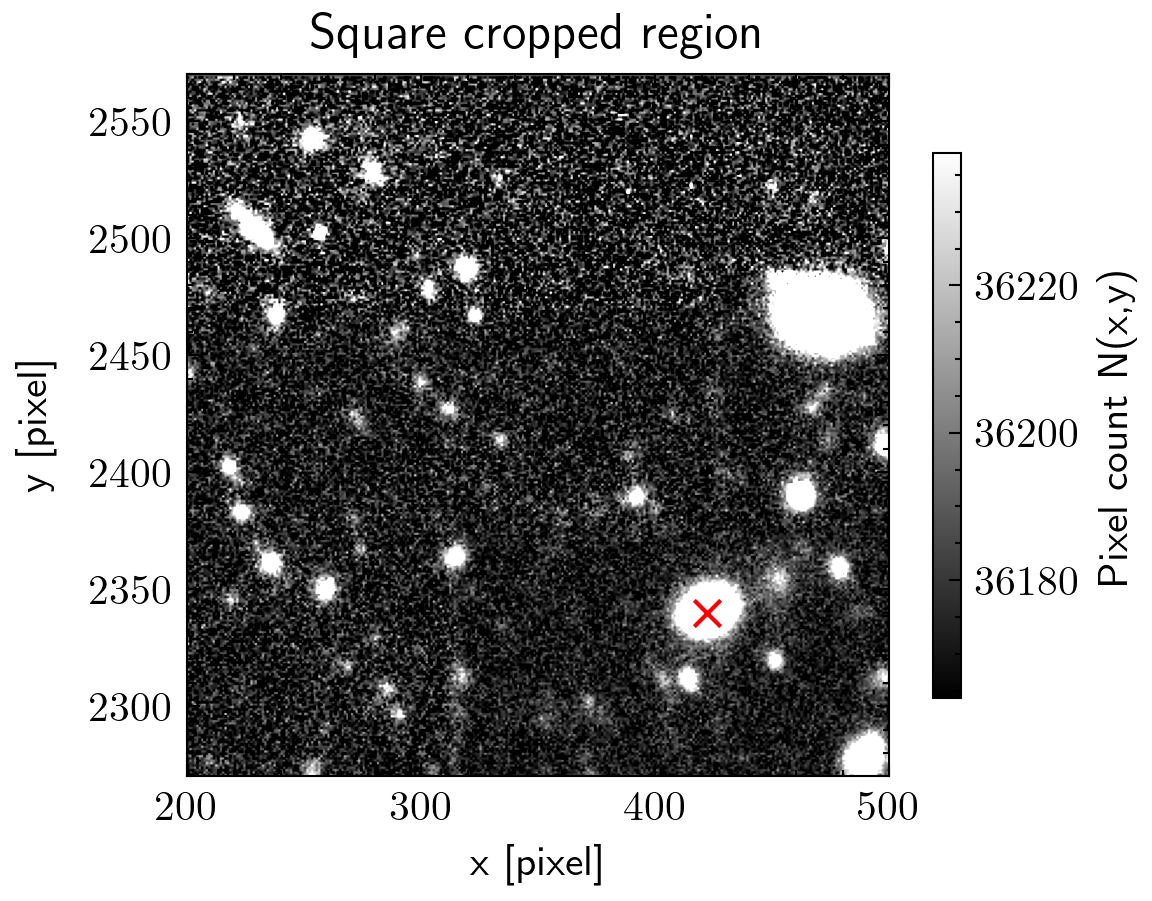

In [252]:
# Pick a clean region for now
size = 300
ny, nx = scaled_image.shape  

# Top-left crop: y from ny - size → ny, x from 0 → size
crop = scaled_image[ny - size : ny, 200 : size + 200]

# Find brightest pixel (absolute coordinates)
y_local, x_local = np.unravel_index(np.argmax(crop), crop.shape)
x_abs = 200 + x_local
y_abs = (ny - size) + y_local
max_val = crop[y_local, x_local]

print(f"Brightest pixel value = {max_val:.2f}")
print(f"Absolute coordinates (x, y) = ({x_abs}, {y_abs})")

# Plot with proper color scaling
plt.figure(figsize=(4, 4), dpi=300)
im = plt.imshow(
    crop,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(scaled_image, 5),
    vmax=np.percentile(scaled_image, 95),
    extent=[200, size + 200, ny - size, ny]
)
plt.scatter(x_abs, y_abs, color='red', marker='x', s=40)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.title('Square cropped region')
plt.colorbar(im, label='Pixel count N(x,y)', shrink=0.5)
plt.tight_layout()
plt.show()
